In [122]:
import numpy as np
from scipy.integrate import quad, tplquad
import vtk
import pyvista as pv

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt

## Problem description

The goal is to solve the Heat equation with no flux boundary condition in 2D on a square domain using the finite element method.<br>
The strong form of the heat equation is given by:

$ \frac{\partial u}{\partial t} = c \Delta u$ on $\Omega$ <br>
where $\Omega$ is the domain of interest anc c is a diffusion coefficient constant across space and time. <br>

The Neuman boundary conditions are given by: <br>
$\nabla u \cdot \hat{n} = 0$ on $\Gamma$ <br>
where $\Gamma$ is the boundary of the domain and were $n$ is the outward normal vector to the boundary. <br>

We will solve this equation using the Garlekin method of weighted residuals. The weak form of the Heat equation is given by:

$ \int_{\Omega}  \frac{\partial u}{\partial t} \, \phi_j \;  d\Omega -   c\int_{\Omega} \Delta u \phi_j \; d\Omega = 0$ where $\phi_j$ is a test function.

After applying Green's first identity, we obtain:

$\int_{\Omega}  \frac{\partial u}{\partial t} \, \phi_j \;  d\Omega  + c \int_{\Omega} \nabla u \cdot \nabla \phi_j \; d\Omega  = \int_{\Gamma} \phi_j \nabla u \cdot n \;  d\Gamma$

Now we expand $u(t, x, y)$ in terms of a finite element basis functions $u(t, x, y) = \sum_{i} \alpha_i(t) \cdot \phi_i(x,y)$:

$\sum_{i} \frac{d \alpha_i}{d t} \, \int_{\Omega}   \phi_i \phi_j \;  d\Omega  + c \sum_{i} \alpha_i \int_{\Omega} \nabla  \phi_i \cdot \nabla \phi_j \; d\Omega  = \int_{\Gamma} \phi_j \nabla u \cdot n \;  d\Gamma$

We can write this in matrix form as:
$M \frac{d \vec{\alpha}}{d t} + c K \vec{\alpha} = c \vec{b} $

We solve this system of equations over time with the backward Euler method (Implicit time integrator):

$M \frac{\vec{\alpha}^{n+1} -  \vec{\alpha}^{n} }{h} + c K \vec{\alpha}^{n+1} = c \vec{b} $ where h is the time step.

$M \vec{\alpha}^{n+1} + c h K \vec{\alpha}^{n+1} = M \vec{\alpha}^{n} + c h \vec{b} $

$\left[ M + c h K \right] \vec{\alpha}^{n+1} = M \vec{\alpha}^{n} + c h \vec{b} $

Since we have homogeneous Neuman boundary conditions, the boundary term on the right hand side of the weak form is zero.

$\left[ M + c h K \right] \vec{\alpha}^{n+1} = M \vec{\alpha}^{n}$



To interpolate $u$ in our triangular elements, we will use a first order Lagrange basis function. 
The basis functions in the element are given by:

$\phi_1(u,v,w) = u$

$\phi_2(u,v,w) = v$

$\phi_3(u,v,w) = w$

$\phi_4(u,v,w) = 1-u-v-w$

Where $u$, $v$, and $w$ are the barycentric coordinates of a point in the element.

In [123]:
class Face: 
    def __init__(self, vertices, cell_1 = -1, cell_2 = -1):
        self.vertices   = vertices
        self.cell_1     = cell_1
        self.cell_2     = cell_2

    def add_cell(self, cell):
        if self.cell_1 == None:
            self.cell_1 = cell
        else:
            self.cell_2 = cell

    def is_boundary_face(self):
        return self.cell_2 == -1
    
    def __hash__(self):
        return tuple(sorted(self.vertices))
    
    def __eq__(self, other):
        return self.__hash__() == other.__hash__()

In [124]:
reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName("tetrahedralized_cube.vtk")
reader.Update()
u_grid = reader.GetOutput()

# Collect the positions of the nodes
n_nodes = u_grid.GetNumberOfPoints()
node_lst = [u_grid.GetPoint(i) for i in range(n_nodes)]
point_ar = np.array(node_lst)
n_vertices = point_ar.shape[0]

cell_lst = []
#Loop over the cells in the VTK mesh (not all vtk cells are tetrahedra)
for cell_id in range(u_grid.GetNumberOfCells()):

    cell = u_grid.GetCell(cell_id)
    n_cell_pts = cell.GetNumberOfPoints()

    #If the cell is a tetrahedron
    if n_cell_pts == 4:

        # Get the points of the cell
        cell_lst.append([cell.GetPointId(i) for i in range(n_cell_pts)])

# Store the faces of the mesh in this dictionary
face_dic = {}

# Loop over the tetrahedra in the mesh
for cell_id, cell_pts in enumerate(cell_lst):
    face_0 = [cell_pts[0], cell_pts[1], cell_pts[2]]
    face_1 = [cell_pts[0], cell_pts[1], cell_pts[3]]
    face_2 = [cell_pts[0], cell_pts[2], cell_pts[3]]
    face_3 = [cell_pts[1], cell_pts[2], cell_pts[3]]

    #Create the faces
    face_0 = Face(face_0, cell_id)
    face_1 = Face(face_1, cell_id)
    face_2 = Face(face_2, cell_id)
    face_3 = Face(face_3, cell_id)

    # Check if the faces are already in the dictionary
    face_0_dic = face_dic.get(face_0.__hash__(), None)
    face_1_dic = face_dic.get(face_1.__hash__(), None)
    face_2_dic = face_dic.get(face_2.__hash__(), None)
    face_3_dic = face_dic.get(face_3.__hash__(), None)

    if face_0_dic is None: face_dic[face_0.__hash__()] = face_0
    else: face_0_dic.add_cell(cell_id)

    if face_1_dic is None: face_dic[face_1.__hash__()] = face_1
    else: face_1_dic.add_cell(cell_id)
        
    if face_2_dic is None: face_dic[face_2.__hash__()] = face_2
    else: face_2_dic.add_cell(cell_id)

    if face_3_dic is None: face_dic[face_3.__hash__()] = face_3
    else: face_3_dic.add_cell(cell_id)


# The point IDs of the tetrahedral cells
cell_ar = np.array(cell_lst)
n_cells = cell_ar.shape[0]

# The point IDs of the faces
face_ar =       np.array([f.vertices for f in face_dic.values()])
n_faces = face_ar.shape[0]

# The cell sharing each face
face_cell_ar =  np.array([[f.cell_1, f.cell_2] for f in face_dic.values()])

# Store for each tetrahedron the faces that it contains
cell_face_lst = [[] for _ in range(cell_ar.shape[0])]

for face_id, (cell_1, cell_2) in enumerate(face_cell_ar):
    if cell_1 != -1: cell_face_lst[cell_1].append(face_id)
    if cell_2 != -1: cell_face_lst[cell_2].append(face_id)

cell_face_ar = np.array(cell_face_lst)

# We need to collect all the boundary points
boundary_faces_idx = np.argwhere(face_cell_ar[:, 1] == -1).flatten()

# Collect the points of the boundary faces
boundary_points = np.unique(face_ar[boundary_faces_idx].flatten())
boundary_point_mask = np.zeros(n_vertices, dtype=bool)
boundary_point_mask[boundary_points] = True

In [125]:
def basis_fn_1(u, v, w): return u
def basis_fn_2(u, v, w): return v
def basis_fn_3(u, v, w): return w
def basis_fn_4(u, v, w): return 1 - u - v - w

grad_basis_fn_1 = np.array([1,   0,  0])
grad_basis_fn_2 = np.array([0,   1,  0])
grad_basis_fn_3 = np.array([0,   0,  1])
grad_basis_fn_4 = np.array([-1, -1, -1])

basis_fn_lst =      [basis_fn_1, basis_fn_2, basis_fn_3, basis_fn_4]
grad_basis_fn_lst = [grad_basis_fn_1, grad_basis_fn_2, grad_basis_fn_3, grad_basis_fn_4]
n_local_basis_fn = len(basis_fn_lst)

In [126]:
#Integrate the product of the basis functions over the reference triangle

#This is the mass matrix for the reference triangle
M_reference = np.zeros((n_local_basis_fn, n_local_basis_fn))

for i in range(n_local_basis_fn):
    for j in range(i, n_local_basis_fn):
        
        M_reference[i, j] = tplquad(
            lambda u, v, w: basis_fn_lst[i](u, v, w) * basis_fn_lst[j](u, v, w), 
            0, 1, 
            0, lambda u: 1 - u, 
            0, lambda u, v: 1 - u - v
        )[0]
        
        M_reference[j, i] = M_reference[i, j] 

In [ ]:
# For each triangle in the mesh we need to compute the Jacobian of the map from global to local coordinates
p0_ar = point_ar[cell_ar[:, 0]]
p1_ar = point_ar[cell_ar[:, 1]]
p2_ar = point_ar[cell_ar[:, 2]]
p3_ar = point_ar[cell_ar[:, 3]]

p3_to_p0_ar = p0_ar - p3_ar
p3_to_p1_ar = p1_ar - p3_ar
p3_to_p2_ar = p2_ar - p3_ar

# Contruct the Jacobian matrices of the map from the reference tetrhedron to the physical tetrahedron for each cell
jacobian_ar = np.zeros((n_cells, 3, 3))

jacobian_ar[:, 0, 0] = p3_to_p0_ar[:, 0]
jacobian_ar[:, 0, 1] = p3_to_p0_ar[:, 1]
jacobian_ar[:, 0, 2] = p3_to_p0_ar[:, 2]

jacobian_ar[:, 1, 0] = p3_to_p1_ar[:, 0]
jacobian_ar[:, 1, 1] = p3_to_p1_ar[:, 1]
jacobian_ar[:, 1, 2] = p3_to_p1_ar[:, 2]

jacobian_ar[:, 2, 0] = p3_to_p2_ar[:, 0]
jacobian_ar[:, 2, 1] = p3_to_p2_ar[:, 1]
jacobian_ar[:, 2, 2] = p3_to_p2_ar[:, 2]

#Compute the determinant of each Jacobian matrix
det_jacobian_ar = np.linalg.det(jacobian_ar)

# Invert the Jacobian matrices
inv_jacobian_ar = np.linalg.inv(jacobian_ar)


#This list stores the product of the gradient of the basis functions with the inverse of the Jacobian
grad_basis_fn_inv_jacobian_lst = [np.dot(inv_jacobian_ar, grad_basis_fn_lst[i]) for i in range(n_local_basis_fn)]

#Now we compute the local mass matrix for each triangle
local_stiffness_matrix_ar   = np.zeros((n_cells, n_local_basis_fn, n_local_basis_fn))
local_mass_matrix_ar        = np.zeros((n_cells, n_local_basis_fn, n_local_basis_fn))


#Compute the local stiffness and mass matrices
for i in range(n_local_basis_fn):
    for j in range(i, n_local_basis_fn):
 
        #Stiffness matrix
        local_stiffness_matrix_ar[:, i, j] = (1.0/6.0) * det_jacobian_ar * np.sum(grad_basis_fn_inv_jacobian_lst[i] * grad_basis_fn_inv_jacobian_lst[j], axis = 1)
        local_stiffness_matrix_ar[:, j, i] = local_stiffness_matrix_ar[:, i, j]

        #Mass matrix
        local_mass_matrix_ar[:, i, j] =  det_jacobian_ar * M_reference[i, j]


#Now we need to assemble the global stiffness matrix
row_id = np.repeat(cell_ar, n_local_basis_fn).flatten()
col_id = np.tile(cell_ar, n_local_basis_fn).flatten()


stiffness_data   = local_stiffness_matrix_ar.flatten()
mass_data = local_mass_matrix_ar.flatten()

# Create the sparse global stiffness matrix
global_stiffness_matrix = csc_matrix((stiffness_data.flatten(), (row_id, col_id)), shape=(n_vertices, n_vertices))
global_mass_matrix =      csc_matrix((mass_data.flatten(), (row_id, col_id)), shape=(n_vertices, n_vertices))

global_stiffness_matrix.sum_duplicates()
global_mass_matrix.sum_duplicates()

[[11.1233827   6.47267562  8.61745327]
 [-7.4483866  -8.17037806 -1.93420225]
 [ 2.45911284  3.83095317 -0.49488799]
 ...
 [ 0.          5.94553133  0.        ]
 [ 1.37451299 -2.89217865 -5.2086154 ]
 [ 7.40512478  0.27514591 -0.97076255]]
(1140, 3)
4


In [128]:
# Apply the Dirichlet boundary conditions
global_stiffness_matrix_with_BC = global_stiffness_matrix[~boundary_point_mask, :]
global_stiffness_matrix_with_BC = global_stiffness_matrix_with_BC[:, ~boundary_point_mask]

global_mass_matrix_with_BC = global_mass_matrix[~boundary_point_mask, :]
global_mass_matrix_with_BC = global_mass_matrix_with_BC[:, ~boundary_point_mask]

/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(
MESA-LOADER: failed to open zink: /opt/amdgpu/lib/x86_64-linux-gnu/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /opt/amdgpu/lib/x86_64-linux-gnu/dri, suffix _dri)
failed to load driver: zink


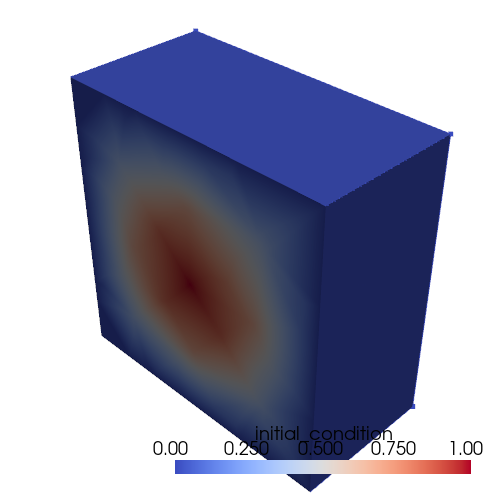

In [129]:
initial_condition = np.sin(np.pi * point_ar[:, 0]) * np.sin(np.pi * point_ar[:, 1]) * np.sin(np.pi * point_ar[:, 2])

pv_before_mesh = pv.wrap(u_grid)
pv_before_mesh.point_data["initial_condition"] = initial_condition
pv_before_mesh = pv_before_mesh.clip(normal=(1, 0, 0), origin=(0.5, 0.5, 0.5))  # Plane normal = (1, 0, 0)


# Create a plotter for Jupyter Notebooks
pv.start_xvfb()  # Needed for some environments (e.g., remote servers)
plotter = pv.Plotter(notebook=True, window_size=(500, 500))
plotter.add_mesh(pv_before_mesh, scalars="initial_condition", cmap="coolwarm", clim= [0,1])
plotter.show()

In [130]:
#Compute the update matrix
time_step = 0.01
diffusion_coefficient = 1.0

# The initial condition at the interior points
initial_condition_interior_points = initial_condition[~boundary_point_mask]

# The update matrix
update_matrix_with_BC = global_mass_matrix_with_BC + time_step * diffusion_coefficient * global_stiffness_matrix_with_BC

#Advance the system by one time step
fem_solution_interior_point = spsolve(update_matrix_with_BC, global_mass_matrix_with_BC.dot(initial_condition_interior_points))

fem_solution = np.zeros(n_vertices)
fem_solution[~boundary_point_mask] = fem_solution_interior_point

/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(
MESA-LOADER: failed to open zink: /opt/amdgpu/lib/x86_64-linux-gnu/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /opt/amdgpu/lib/x86_64-linux-gnu/dri, suffix _dri)
failed to load driver: zink


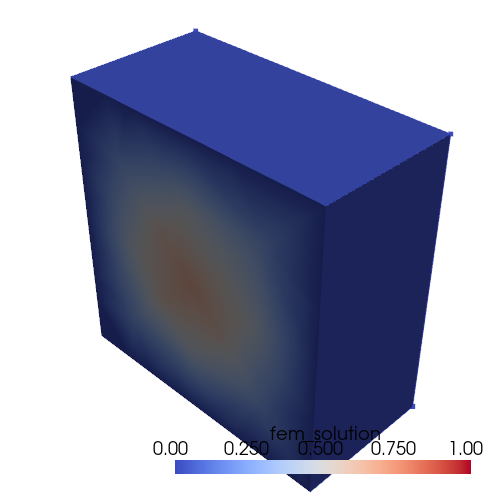

In [131]:
pv_after_mesh = pv.wrap(u_grid)
pv_after_mesh.point_data["fem_solution"] = fem_solution
pv_after_mesh = pv_after_mesh.clip(normal=(1, 0, 0), origin=(0.5, 0.5, 0.5))  # Plane normal = (1, 0, 0)

# Create a plotter for Jupyter Notebooks
pv.start_xvfb()  # Needed for some environments (e.g., remote servers)
plotter = pv.Plotter(notebook=True, window_size=(500, 500))
plotter.add_mesh(pv_after_mesh, scalars="fem_solution", cmap="coolwarm", clim= [0,1])
plotter.show()


/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(
MESA-LOADER: failed to open zink: /opt/amdgpu/lib/x86_64-linux-gnu/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /opt/amdgpu/lib/x86_64-linux-gnu/dri, suffix _dri)
failed to load driver: zink


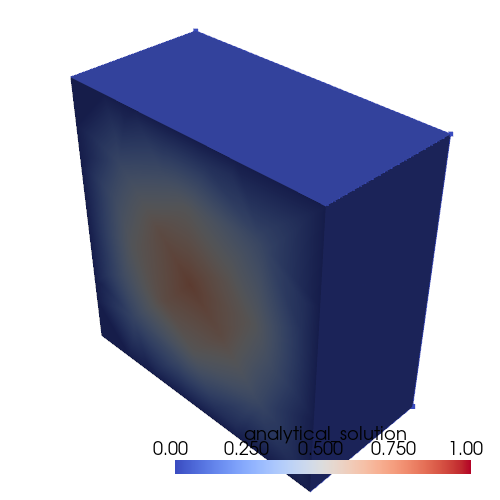

In [132]:
analytical_solution  = np.sin(np.pi * point_ar[:, 0]) * np.sin(np.pi * point_ar[:, 1]) * np.sin(np.pi * point_ar[:, 2]) * np.exp(-3 * np.pi**2 * time_step)

pv_analytical_mesh = pv.wrap(u_grid)
pv_analytical_mesh.point_data["analytical_solution"] = analytical_solution
pv_analytical_mesh = pv_analytical_mesh.clip(normal=(1, 0, 0), origin=(0.5, 0.5, 0.5))  # Plane normal = (1, 0, 0)

# Create a plotter for Jupyter Notebooks
pv.start_xvfb()  # Needed for some environments (e.g., remote servers)
plotter = pv.Plotter(notebook=True, window_size=(500, 500))
plotter.add_mesh(pv_analytical_mesh, scalars="analytical_solution", cmap="coolwarm", clim= [0,1])
plotter.show()

In [133]:
print(np.max(initial_condition))
print(np.max(fem_solution))
print(np.max(analytical_solution))

1.0
0.6744628849014851
0.7437218794107743


/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(
MESA-LOADER: failed to open zink: /opt/amdgpu/lib/x86_64-linux-gnu/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /opt/amdgpu/lib/x86_64-linux-gnu/dri, suffix _dri)
failed to load driver: zink


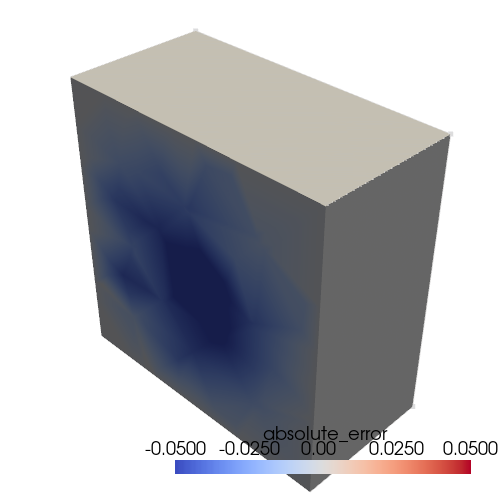

In [134]:
absolute_error = fem_solution - analytical_solution

pv_error_mesh = pv.wrap(u_grid)
pv_error_mesh.point_data["absolute_error"] = absolute_error
pv_error_mesh = pv_error_mesh.clip(normal=(1, 0, 0), origin=(0.5, 0.5, 0.5))  # Plane normal = (1, 0, 0)

# Create a plotter for Jupyter Notebooks
pv.start_xvfb()  # Needed for some environments (e.g., remote servers)
plotter = pv.Plotter(notebook=True, window_size=(500, 500))
plotter.add_mesh(pv_error_mesh, scalars="absolute_error", cmap="coolwarm", clim= [-0.05,0.05])
plotter.show()

/tmp/ipykernel_91406/1718462108.py:1: RuntimeWarning: invalid value encountered in divide
  relative_error = np.where(analytical_solution > 0.01, np.abs(absolute_error) * 100.0 / np.abs(analytical_solution), 0)
/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(
MESA-LOADER: failed to open zink: /opt/amdgpu/lib/x86_64-linux-gnu/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /opt/amdgpu/lib/x86_64-linux-gnu/dri, suffix _dri)
failed to load driver: zink


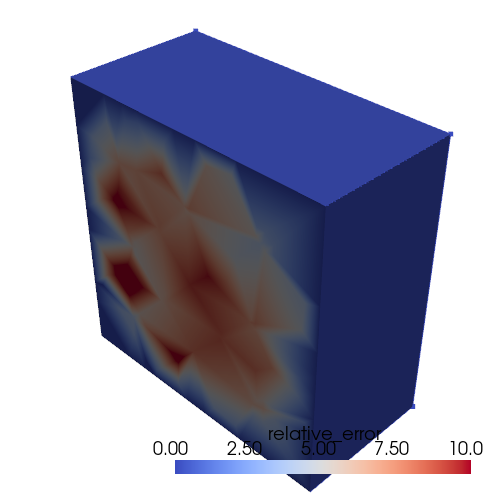

In [135]:
relative_error = np.where(analytical_solution > 0.01, np.abs(absolute_error) * 100.0 / np.abs(analytical_solution), 0)


pv_relative_error_mesh = pv.wrap(u_grid)
pv_relative_error_mesh.point_data["relative_error"] = relative_error
pv_relative_error_mesh = pv_relative_error_mesh.clip(normal=(1, 0, 0), origin=(0.5, 0.5, 0.5))  # Plane normal = (1, 0, 0)


# Create a plotter for Jupyter Notebooks
pv.start_xvfb()  # Needed for some environments (e.g., remote servers)
plotter = pv.Plotter(notebook=True, window_size=(500, 500))
plotter.add_mesh(pv_relative_error_mesh, scalars="relative_error", cmap="coolwarm", clim= [0, 10])
plotter.show()
